<div align='center'><font size='4'><b>Проект построения модели машинного обучения для предсказания температуры плавления стали на металлургическом предприятии с целью оптимизации производственных расходов.</b></font></div>

<font size='3'><b>Цель проекта:</b></font>

Построить модель предсказания температуры плавления стали, для уменьшения потребление электроэнергии на этапе обработки стали. Метрикой качества модели является MAE. Необходимо получить на тестовых данных MAE < 6.8

<font size='3'><b>Описание этапа обработки:<b/></font>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

<font size='3'><b>Описание данных:</b></font>

Данные состоят из файлов, полученных из разных источников

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


<div align='center'><font size='4'><b>План проекта.</b></font></div>


 **1) Изучить и проанализировать данные**

 - Получить отчеты об исходных данных 
 - Провести визуальный анализ с помощью построенных графиков
 - Если есть проблемы и аномалии в данных,определитить, что с эти делать 
 - Сформулировать вопросы по моделируемому процессу для бизнеса

**2) Предобработать данные**

 - Удалить ненужные данные.
 - Столбцы в таблицах переименовать в стандартный вид.
 - Обработать пропуски и выбросы.
 - Определить и убрать признаки,не влияющие на результаты моделирования.
 - Добавить дополнительные признаки,исходя из имеющихся данных, которые могут улучшить качество моделирования.
 - Преодбработанные данные обьединить в общую таблицу для моделирования.

**3) Подготовить  выборки для моделирования**

 - Из подготовленной общей таблицы выделить целевой и вспомогательные признаки.
 - Разделить целевой и вспомогательный признаки на тренировочную и тестовую выборки в соотношении 0.75/0.25.

**4) Обучить модели и выбрать наилучшую**

- Выбрать несколько типов моделей регрессии
- Подобрать наилучшие параметры моделей и обучить с этими параметрами исследуемые модели на тренировочной выборке.
- По результатам обучения моделей (наименьшая МАЕ) определить наиболее успешную модель.


**5) Проверить модель**

- Проверить выбранную модель на тестовой выборке с целью получения МАЕ не хуже установленной.
- Проверить модель на адекватность
- Рассмотерть важность параметров, которые наибольшим образовм влияют на качество модели.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

## Изучение данных

Загружаю исходные данные

In [2]:
arc = pd.read_csv('/datasets/data_arc_new.csv')
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
gas = pd.read_csv('/datasets/data_gas_new.csv')
temp = pd.read_csv('/datasets/data_temp_new.csv')
wire = pd.read_csv('/datasets/data_wire_new.csv')
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

Создаю процедуру для вывода основной информации по таблицам

In [3]:
def inf(data):
    display(data.head(10))
    display(data.info())
    display(data.drop('key', axis=1).describe().T)
    total = data.isna().sum().sort_values(ascending = False)
    percent = (data.isna().sum()/data.isna().count()*100).sort_values(ascending = False)
    print(f'Размер датафрейма:',  data.shape)
    print(f'Количество дубликатов датафрейма:', data.duplicated().sum())
    print(f'Количество пропусков датафрейма:',  total.sum())
    print(f'Процент пропусков датафрейма:',  round((percent.sum()/percent.count()),2))
    print('')
    print('Таблица пропусков по столбцам')
    print('------------------------------')
    print(pd.concat([total, round(percent,2)], axis=1, keys=['Total', 'Percent']))
    

### Данные об электродах

In [4]:
inf(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


Размер датафрейма: (14876, 5)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 0
Процент пропусков датафрейма: 0.0

Таблица пропусков по столбцам
------------------------------
                      Total  Percent
key                       0      0.0
Начало нагрева дугой      0      0.0
Конец нагрева дугой       0      0.0
Активная мощность         0      0.0
Реактивная мощность       0      0.0


Переименовываю столбцы на русском языке.

In [5]:
arc_col = {
    'Начало нагрева дугой': 'arc_heat_start',
    'Конец нагрева дугой': 'arc_heat_finish',
    'Активная мощность': 'apparent_power',
    'Реактивная мощность': 'reactive_power',
}
arc = arc.rename(columns=arc_col)

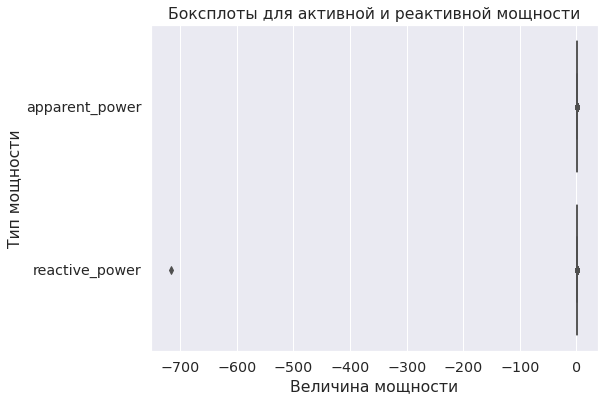

In [6]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.3)           
bulk_plot = sns.boxplot(data=arc.drop('key', axis=1),orient='h',palette ='rainbow')
bulk_plot.set(xlabel ="Величина мощности", ylabel = "Тип мощности", title ='Боксплоты для активной и реактивной мощности');

Смотрю количество аномалий.

In [7]:
arc[arc['reactive_power']<0].count()

key                1
arc_heat_start     1
arc_heat_finish    1
apparent_power     1
reactive_power     1
dtype: int64

Удаляю отрицательные значения реактивной мощности в созданном файле для боксплота.

In [8]:
arc_for_boxplot = arc[arc['reactive_power']>=0]

Для визуализации строю графики.

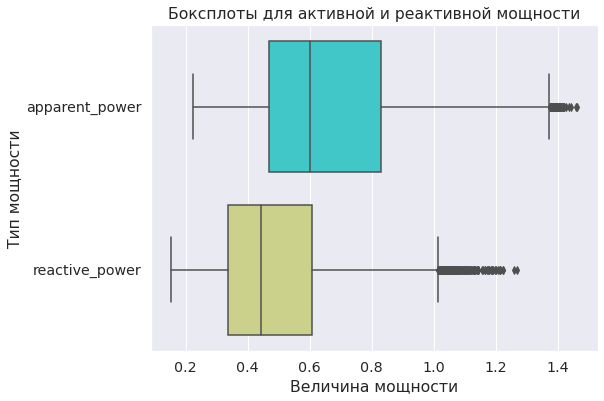

In [9]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.3)           
bulk_plot = sns.boxplot(data=arc_for_boxplot.drop('key', axis=1),orient='h',palette ='rainbow')
bulk_plot.set(xlabel ="Величина мощности", ylabel = "Тип мощности", title ='Боксплоты для активной и реактивной мощности');

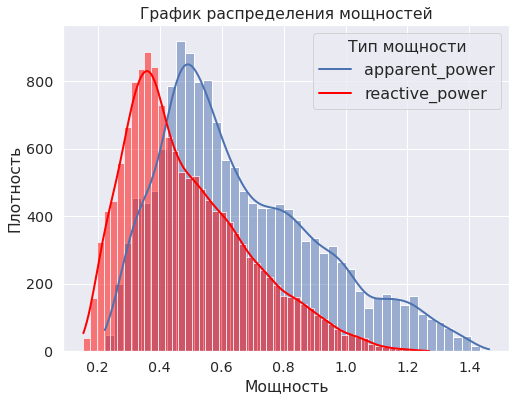

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(arc_for_boxplot['apparent_power'], kde=True, line_kws={'linewidth':2})
sns.histplot(arc_for_boxplot['reactive_power'], kde=True, line_kws={'linewidth':2},color = 'red')

plt.legend(prop={'size': 16}, title = 'Тип мощности',labels = ['apparent_power', 'reactive_power'])
plt.title('График распределения мощностей')
plt.xlabel('Мощность')
plt.ylabel('Плотность');

В таблице arc содержатся данные об активной и реактивной мощностях электродов при нагреве сырья, времени начала нагрева и конце.
 - Используя эти данные можно посчитать полную мощность, вычислить время нагрева, перемножив их получить дополнительный признак   значение энергии используемой при легировании стали. 
 - Пропусков в таблице нет.
 - Есть аномалия в значении реактивной мощности - отрицательное значение, что является ошибкой. Удалив отрицательное значение, получил нормальный боксплот.
 - Названия столбцов были на русском языке, переименовал столбцы по стандартным правилам.
 - Некоторые значения мощностей портят картину нормального распределения, распределение смещено влево. **УТОЧНИТЬ -->** Может быть повышенные значения мощностей есть особенность технологического процесса легирования.


### Данные о подаче сыпучих материалов (объём)

In [11]:
inf(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,count,mean,std,min,25%,50%,75%,max
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0
Bulk 10,176.0,83.284091,26.060347,24.0,64.00,86.5,102.00,159.0


Размер датафрейма: (3129, 16)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 35776
Процент пропусков датафрейма: 71.46

Таблица пропусков по столбцам
------------------------------
         Total  Percent
Bulk 8    3128    99.97
Bulk 13   3111    99.42
Bulk 9    3110    99.39
Bulk 2    3107    99.30
Bulk 7    3104    99.20
Bulk 5    3052    97.54
Bulk 10   2953    94.38
Bulk 11   2952    94.34
Bulk 1    2877    91.95
Bulk 6    2553    81.59
Bulk 4    2115    67.59
Bulk 3    1831    58.52
Bulk 15    881    28.16
Bulk 12    679    21.70
Bulk 14    323    10.32
key          0     0.00


Привожу названия столбцов к стандартному виду.

In [12]:
bulk_col = {'Bulk 1': 'bulk_1','Bulk 2': 'bulk_2','Bulk 3': 'bulk_3','Bulk 4': 'bulk_4','Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6','Bulk 7': 'bulk_7','Bulk 8': 'bulk_8','Bulk 9': 'bulk_9','Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11','Bulk 12': 'bulk_12','Bulk 13': 'bulk_13','Bulk 14': 'bulk_14','Bulk 15': 'bulk_15'}
bulk = bulk.rename(columns=bulk_col)

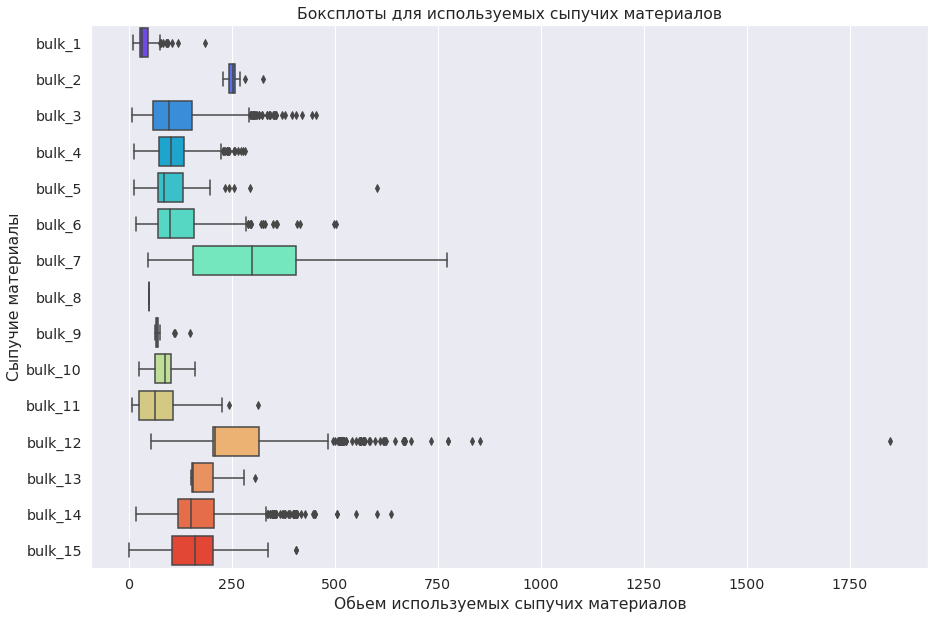

In [13]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.3)           
bulk_plot = sns.boxplot(data=bulk.drop('key', axis=1),orient='h',palette ='rainbow')
bulk_plot.set(xlabel ="Обьем используемых сыпучих материалов", ylabel = "Cыпучие материалы", \
              title ='Боксплоты для используемых сыпучих материалов');

В таблице bulk информация об обьеме сыпучих примесей для химического процесса легирования 
 - Как видно из аналитики 71,46% данных пропущено
 - Почти все признаки имеют выбросами
 - Примесь bulk_12 имеет аномальный выброс в обьеме ~1800 <s>что в несколько раз больше нормальных значений, думаю можно удалить.</s> 
 - некотрорые примеси добавлялись 1 раз, как например bulk_8, такую примесь можно удалить
 - а остальные пропуски можно заполнить нулями.

### Данные о подаче сыпучих материалов (время)

In [14]:
inf(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,count,unique,top,freq
Bulk 1,252,252,2019-08-12 19:51:09,1
Bulk 2,22,22,2019-05-08 01:46:58,1
Bulk 3,1298,1298,2019-09-03 04:06:31,1
Bulk 4,1014,1014,2019-05-20 10:37:26,1
Bulk 5,77,77,2019-07-27 05:21:58,1
Bulk 6,576,576,2019-07-31 03:52:07,1
Bulk 7,25,25,2019-05-07 18:11:01,1
Bulk 8,1,1,2019-07-08 17:14:53,1
Bulk 9,19,19,2019-08-16 06:07:48,1
Bulk 10,176,176,2019-08-29 14:04:23,1


Размер датафрейма: (3129, 16)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 35776
Процент пропусков датафрейма: 71.46

Таблица пропусков по столбцам
------------------------------
         Total  Percent
Bulk 8    3128    99.97
Bulk 13   3111    99.42
Bulk 9    3110    99.39
Bulk 2    3107    99.30
Bulk 7    3104    99.20
Bulk 5    3052    97.54
Bulk 10   2953    94.38
Bulk 11   2952    94.34
Bulk 1    2877    91.95
Bulk 6    2553    81.59
Bulk 4    2115    67.59
Bulk 3    1831    58.52
Bulk 15    881    28.16
Bulk 12    679    21.70
Bulk 14    323    10.32
key          0     0.00


В таблице bulk_time информация об времени добавления сыпучих примесей для химического процесса легирования

- Как видно из аналитики 71,46% данных пропущено
- У меня есть предположение, что признаки из этой таблицы можно не использовать при моделировании
- Пока не буду переименовывать столбцы, тк эта таблица может не понадобится.

### Данные о продувке сплава газом

In [15]:
inf(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,count,mean,std,min,25%,50%,75%,max
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Размер датафрейма: (3239, 2)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 0
Процент пропусков датафрейма: 0.0

Таблица пропусков по столбцам
------------------------------
       Total  Percent
key        0      0.0
Газ 1      0      0.0


Привожу название столбца к стандартному виду.

In [16]:
gas = gas.rename(columns={'Газ 1': 'gas'})

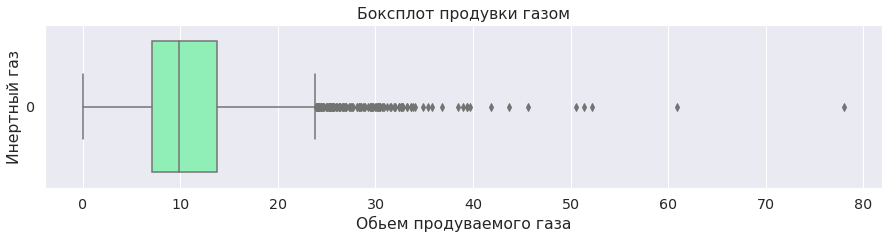

In [17]:
plt.figure(figsize=(15, 3))
sns.set(font_scale=1.3)           
gas_plot = sns.boxplot(data=gas['gas'],orient='h',palette ='rainbow')
gas_plot.set(xlabel ="Обьем продуваемого газа", ylabel = "Инертный газ", \
              title ='Боксплот продувки газом');

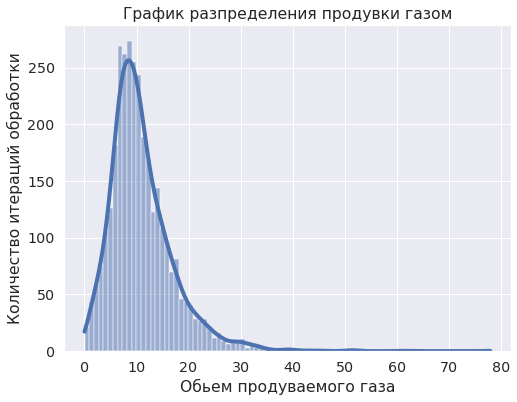

In [18]:
plt.figure(figsize=(8, 6))
gas_histplot = sns.histplot(gas['gas'], kde=True, line_kws={'linewidth':4})
gas_histplot.set(xlabel ="Обьем продуваемого газа", ylabel = 'Количество итераций обработки', \
              title ='График разпределения продувки газом');

В таблице gas информация об обьеме продуваемого газа без привязки по времени.
- Пропусков нет. 
- Распределение данных нормальное со смещением влево
- Начиная с обьема газа  ~35 наблюдаются выбросы

###  Результаты измерения температуры

In [19]:
inf(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
Температура,14665.0,1590.722741,20.394381,1191.0,1580.0,1590.0,1599.0,1705.0


Размер датафрейма: (18092, 3)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 3427
Процент пропусков датафрейма: 6.31

Таблица пропусков по столбцам
------------------------------
              Total  Percent
Температура    3427    18.94
key               0     0.00
Время замера      0     0.00


In [20]:
temp = temp.rename(columns={'Время замера': 'time_check', 'Температура':'temperature'})

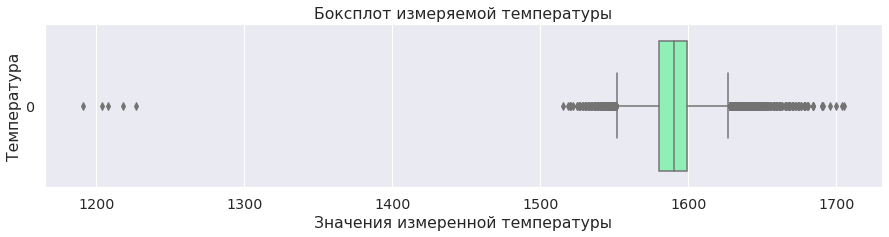

In [21]:
plt.figure(figsize=(15, 3))
sns.set(font_scale=1.3)           
temp_plot = sns.boxplot(data=temp['temperature'],orient='h',palette ='rainbow')
temp_plot.set(xlabel ="Значения измеренной температуры", ylabel = "Температура", \
              title ='Боксплот измеряемой температуры');

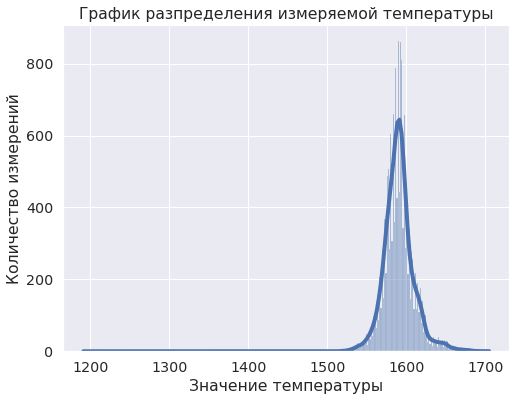

In [22]:
plt.figure(figsize=(8, 6))
temp_histplot = sns.histplot(temp['temperature'], kde=True, line_kws={'linewidth':4})
temp_histplot.set(xlabel ="Значение температуры", ylabel = 'Количество измерений', \
              title ='График разпределения измеряемой температуры');

В таблице temp результаты измерения температурs и целевой признак - конечная температура. 
 - 19% пропусков в целевом признаке, скорее всего такие пропуски придется удалить, чтобы не искажать исследование.
 - Имеются значения температур, колторые значительно ниже температура плавления стали(1450 С - 1535 С), такие выбросы можно удалить. 
 - Данные имеют нормальное распределение.

### Данные о проволочных материалах (объём)

In [23]:
inf(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,count,mean,std,min,25%,50%,75%,max
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Размер датафрейма: (3081, 10)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 23385
Процент пропусков датафрейма: 75.9

Таблица пропусков по столбцам
------------------------------
        Total  Percent
Wire 5   3080    99.97
Wire 7   3070    99.64
Wire 4   3067    99.55
Wire 8   3062    99.38
Wire 9   3052    99.06
Wire 3   3018    97.96
Wire 6   3008    97.63
Wire 2   2002    64.98
Wire 1     26     0.84
key         0     0.00


In [24]:
wire_col = {'Wire 1': 'wire_1','Wire 2': 'wire_2','Wire 3': 'wire_3','Wire 4': 'wire_4','Wire 5': 'wire_5',
    'Wire 6': 'wire_6','Wire 7': 'wire_7','Wire 8': 'wire_8','Wire 9': 'wire_9'}
wire = wire.rename(columns=wire_col)

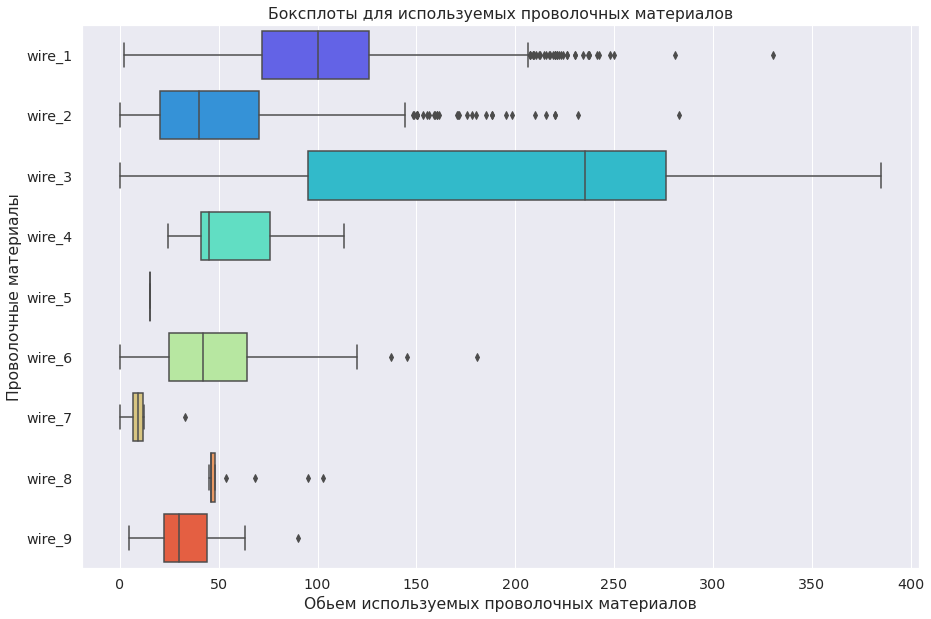

In [25]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.3)           
wire_plot = sns.boxplot(data=wire.drop('key', axis=1),orient='h',palette ='rainbow')
wire_plot.set(xlabel ="Обьем используемых проволочных материалов", ylabel = "Проволочные материалы", \
              title ='Боксплоты для используемых проволочных материалов');

В таблице wire содержатся данные об обьеме проволочных примесей для корректировки химического состава.
 - в таблице 75,9% пропусков, так как, скорее всего, какая-либо примесь могла просто не добавляться. Такие пропуски можно заполнить нулями.
 - в Wire 1 Wire 2 больше всего аномальных значений. Посмотрю на поведение модели, если результат не будет удовлетворять можно попробовать удалить выбросы из обучающей выборки после разбиения.
 - Wire 5 добавляли вероятно один раз.Думаю можно удалить.

### Данные о проволочных материалах (время)

In [26]:
inf(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,count,unique,top,freq
Wire 1,3055,3055,2019-06-24 20:41:09,1
Wire 2,1079,1079,2019-07-06 07:49:41,1
Wire 3,63,63,2019-06-10 15:07:04,1
Wire 4,14,14,2019-08-12 19:51:09,1
Wire 5,1,1,2019-08-13 06:14:30,1
Wire 6,73,73,2019-05-09 02:52:53,1
Wire 7,11,11,2019-07-27 13:43:32,1
Wire 8,19,19,2019-05-14 14:35:02,1
Wire 9,29,29,2019-08-09 10:17:13,1


Размер датафрейма: (3081, 10)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 23385
Процент пропусков датафрейма: 75.9

Таблица пропусков по столбцам
------------------------------
        Total  Percent
Wire 5   3080    99.97
Wire 7   3070    99.64
Wire 4   3067    99.55
Wire 8   3062    99.38
Wire 9   3052    99.06
Wire 3   3018    97.96
Wire 6   3008    97.63
Wire 2   2002    64.98
Wire 1     26     0.84
key         0     0.00


В таблице wire_time информация об времени добавления сыпучих примесей для химического процесса легирования

- Как видно из аналитики 75,9% данных пропущено
- У меня есть предположение, что признаки из этой таблицы можно не использовать при моделировании
- Пока не буду переименовывать столбцы, тк эта таблица может не понадобится.

ВОПРОСЫ ЗАКАЗЧИКУ 

1) При добавлении материалов, какие значения можно считать выбросами? Стоит ли исключить те строки, в которых значения уходят за нормальное распределение и ящиков с усами?

2) Стоит рассчитать общую мощность или лучше уже рассчитать энергию, как дополнительные параметры? Или даже оба параметра оставить?

3) Можно ли удалить из расчета те материалы, которые добавляли слишком редко? 

4) Замеры температуры ниже плавления стали это неисправность или ошибки?

5) Что бы сам заказчик добавил или удалил из данных, с технологической точки зрения? 


## Предобработка данных

### Данные об электродах

В данной таблице, создаю дополнительные признаки

Вычисляю время нагрева ковша электродами в секундах, как разницу между временем окончания нагрева и временем начала нагрева, предварительно переводом данных в формат datetime.

In [27]:
arc['arc_heat_finish'] = pd.to_datetime(arc['arc_heat_finish'], format='%Y-%m-%d %H:%M:%S')
arc['arc_heat_start'] = pd.to_datetime(arc['arc_heat_start'], format='%Y-%m-%d %H:%M:%S')
arc['arc_heat_time'] = (arc['arc_heat_finish'] - arc['arc_heat_start']).dt.seconds

Полная мощность

Вычислим значение полной мощности S:
Соотношение полной мощности с активной и реактивной мощностями выражается в следующем виде:
$$ S=\sqrt{P^2 + Q^2} $$

где  $S$ -полная мощность, 
$P$  - активная мощность, 
$Q$ - реактивная мощность
   

In [28]:
arc['real_power'] = (arc['apparent_power']**2 + arc['reactive_power']**2)**0.5

Энергия

Если заранее известно значение мощности и времени, можно вычислить энергию, представляющую собой произведение обеих величин, что будет весомым дополнительным признаком для нашего моделирования – $$W = S  * Т$$

In [29]:
arc['energy'] = arc['arc_heat_time'] * arc['real_power']

На этапе анализа, было установлено наличие отрицательного значения в реактивной мощности, что скорее всего является ошибкой и такую итерацию нагрева электродов удаляю вместе со всеми итерациями нагревов для данной партии.

In [30]:
del_key = arc.loc[arc['reactive_power'] < 0, 'key'].values[0] # Получаем значение "key"-номер партии с отрицательным значением
arc = arc[arc['key'] != del_key] # Удаляю все строки с найденным значением "key"

Создадим сводную итоговую таблицу, в которой будут общие суммы по партиям:


In [31]:
arc_fin = arc.groupby(by = 'key').sum().reset_index()
arc_fin.info()
arc_fin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             3213 non-null   int64  
 1   apparent_power  3213 non-null   float64
 2   reactive_power  3213 non-null   float64
 3   arc_heat_time   3213 non-null   int64  
 4   real_power      3213 non-null   float64
 5   energy          3213 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 150.7 KB


,key,apparent_power,reactive_power,arc_heat_time,real_power,energy
0,1,3.036730,2.142821,1098,3.718736,770.282114
1,2,2.139408,1.453357,811,2.588349,481.760005
2,3,4.063641,2.937457,655,5.019223,722.837668
3,4,2.706489,2.056992,741,3.400038,683.455597
4,5,2.252950,1.687991,869,2.816980,512.169934


###  Данные о подаче сыпучих материалов (объём)

При анализе данных было установлено, что по некоторым типам материалов почти нет данных и это не поможет нам в построении модели. Установил порог наличия пропусков в 5% по которому исключу такие данные из расчета.

In [32]:
data_treshold = 0.05 # 5% порог на наличие не пустых данных, то что ниже порога будет удалено

columns = bulk.columns
for col in columns:
    if (bulk[col].count() / bulk.shape[0]) < data_treshold:
        bulk = bulk.drop(col, axis=1)

In [33]:
bulk = bulk.fillna(0).astype('int')

In [34]:
bulk.info()
bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int64
 1   bulk_1   3129 non-null   int64
 2   bulk_3   3129 non-null   int64
 3   bulk_4   3129 non-null   int64
 4   bulk_6   3129 non-null   int64
 5   bulk_10  3129 non-null   int64
 6   bulk_11  3129 non-null   int64
 7   bulk_12  3129 non-null   int64
 8   bulk_14  3129 non-null   int64
 9   bulk_15  3129 non-null   int64
dtypes: int64(10)
memory usage: 244.6 KB


,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
0,1,0,0,43,0,0,0,206,150,154
1,2,0,0,73,0,0,0,206,149,154
2,3,0,0,34,0,0,0,205,152,153
3,4,0,0,81,0,0,0,207,153,154
4,5,0,0,78,0,0,0,203,151,152


Таким образом, удалили признаки, где подавляющее количество пропусков:
Bulk 8,   Bulk 13,   Bulk 9,    Bulk 2,    Bulk 7,   Bulk 5    

### Результаты измерения температуры

В таблице с целевым признаком удаляю строки с пропусками, сортирую по времени замера температуры, привожу признак температуры к типу integer.

In [35]:
# Получаем значение "key"-номер партии с пропущенными значениями
del_keys = temp[temp.isnull().any(axis=1)]['key'].unique()
# Оставляем в таблице temp партии не входящие в список del_keys 
temp = temp[~temp['key'].isin(del_keys)].reset_index()

In [36]:
temp = temp.sort_values(by='time_check')
temp['temperature'] = temp['temperature'].astype('int')

In [37]:
temp.head()

,index,key,time_check,temperature
0,0,1,2019-05-03 11:02:04,1571
1,1,1,2019-05-03 11:07:18,1604
2,2,1,2019-05-03 11:11:34,1618
3,3,1,2019-05-03 11:18:04,1601
4,4,1,2019-05-03 11:25:59,1606


In [38]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        13926 non-null  int64 
 1   key          13926 non-null  int64 
 2   time_check   13926 non-null  object
 3   temperature  13926 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 544.0+ KB


Смотрю замеры по каким партиям показывают температуры ниже плавления стали

In [39]:
temp[temp['temperature'] < 1450]

,index,key,time_check,temperature
4883,4883,867,2019-06-06 08:03:39,1191
6784,6784,1214,2019-06-18 08:01:03,1208
9050,9050,1619,2019-07-03 02:34:41,1218
11495,11495,2052,2019-07-25 08:49:15,1227


Удаляю все партии, замеры текмпературы по которым показали температуру ниже плавления стали 1450 градусов.

In [40]:
del_keys = temp[temp['temperature'] < 1450]['key'].unique()
temp = temp[~temp['key'].isin(del_keys)]

Наглядно смотрю, что таких замеров больше нет. 

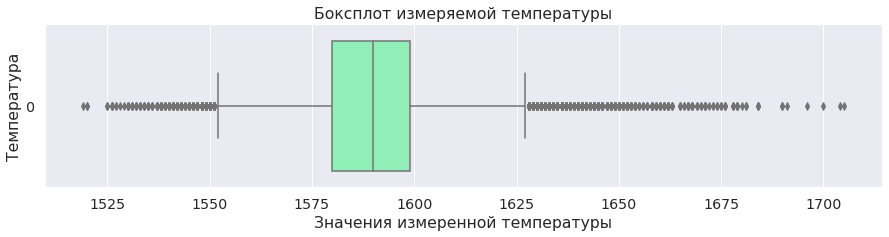

In [41]:
plt.figure(figsize=(15, 3))
sns.set(font_scale=1.3)           
temp_plot = sns.boxplot(data=temp['temperature'],orient='h',palette ='rainbow')
temp_plot.set(xlabel ="Значения измеренной температуры", ylabel = "Температура", \
              title ='Боксплот измеряемой температуры');

Так же,в таблице temp, мы видим обилие замеров темерператур. По каждой партии должно быть минимум 2 замера температуры, последний из которых будет означать, что цель по легированию стали достигнута.

In [42]:
counts = temp['key'].value_counts().reset_index() #считаю количество измерений в партии
counts = counts.rename(columns={'index': 'key', 'key': 'count'})
print(counts)


       key  count
0     2108     17
1     1513     16
2     1689     16
3       46     14
4      322     14
...    ...    ...
2468   530      2
2469  1914      2
2470  1766      2
2471   195      1
2472   279      1

[2473 rows x 2 columns]


Оставляю только те строки, в которых значение в столбце key повторяется несколько раз, что означает, что было более одного замера

In [43]:
temp = temp[~temp['key'].isin(counts[counts['count'] == 1]['key'])]
temp.shape

(13903, 4)

Группирую партии по значениям первого и последнего замеров температуры

In [44]:
temp_fin = temp.groupby('key').agg(first=('temperature', 'first'), last=('temperature', 'last')).reset_index()

Добавляю в таблицу количество замеров температуры, ~~удаляю те строки, где при замере температура не изменилась от начальной и~~,переименовываю столбцы

In [45]:
temp_fin = temp_fin.merge(counts, on='key', how='left')
temp_fin = temp_fin.rename(columns={'first': 'temperature_first', 'last': 'temperature_last','count': 'checking_count'})
temp_fin.head()
temp_fin.shape

(2471, 4)

### Данные о проволочных материалах (объём)

При анализе данных было установлено, что по некоторым типам материалов почти нет данных и это безполезно в построении модели. При наличии пропусков более 5% (установленный ранее порог) избавимся от данных.

In [46]:
columns = wire.columns
for col in columns:
    if (wire[col].count() / wire.shape[0]) < data_treshold:
        wire = wire.drop(col, axis=1)

Пустые значения заменяю нулями

In [47]:
wire = wire.fillna(0)

In [48]:
wire.head()
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


В итоге из таблицы по проволочным материалам были удалены следующие признаки,по которым очень значительное отсутствие информации Wire 5, Wire 7,  Wire 4,  Wire 8,   Wire 9,   Wire 3,   Wire 6   

### Создание итоговой таблицы

Теперь последовательно обьединим таблицы arc_fin, gas, temp_fin, bulk и wire. Данные обьединяем по ключу используем inner_jon (т.е. берем только те партии, где есть все данные)

In [49]:
result = pd.merge(arc_fin, bulk, on='key', how='inner')
result = pd.merge(result, gas, on='key', how='inner')
result = pd.merge(result, temp_fin, on='key', how='inner')
result = pd.merge(result, wire, on='key', how='inner')
result.info()
result.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2324 non-null   int64  
 1   apparent_power     2324 non-null   float64
 2   reactive_power     2324 non-null   float64
 3   arc_heat_time      2324 non-null   int64  
 4   real_power         2324 non-null   float64
 5   energy             2324 non-null   float64
 6   bulk_1             2324 non-null   int64  
 7   bulk_3             2324 non-null   int64  
 8   bulk_4             2324 non-null   int64  
 9   bulk_6             2324 non-null   int64  
 10  bulk_10            2324 non-null   int64  
 11  bulk_11            2324 non-null   int64  
 12  bulk_12            2324 non-null   int64  
 13  bulk_14            2324 non-null   int64  
 14  bulk_15            2324 non-null   int64  
 15  gas                2324 non-null   float64
 16  temperature_first  2324 

,key,apparent_power,reactive_power,arc_heat_time,real_power,energy,bulk_1,bulk_3,bulk_4,bulk_6,...,bulk_11,bulk_12,bulk_14,bulk_15,gas,temperature_first,temperature_last,checking_count,wire_1,wire_2
0,1,3.036730,2.142821,1098,3.718736,770.282114,0,0,43,0,...,0,206,150,154,29.749986,1571,1613,6,60.059998,0.00000
1,2,2.139408,1.453357,811,2.588349,481.760005,0,0,73,0,...,0,206,149,154,12.555561,1581,1602,5,96.052315,0.00000
2,3,4.063641,2.937457,655,5.019223,722.837668,0,0,34,0,...,0,205,152,153,28.554793,1596,1599,6,91.160157,0.00000
3,4,2.706489,2.056992,741,3.400038,683.455597,0,0,81,0,...,0,207,153,154,18.841219,1601,1625,5,89.063515,0.00000
4,5,2.252950,1.687991,869,2.816980,512.169934,0,0,78,0,...,0,203,151,152,5.413692,1576,1602,5,89.238236,9.11456


In [50]:
inf(result)

,key,apparent_power,reactive_power,arc_heat_time,real_power,energy,bulk_1,bulk_3,bulk_4,bulk_6,...,bulk_11,bulk_12,bulk_14,bulk_15,gas,temperature_first,temperature_last,checking_count,wire_1,wire_2
0,1,3.036730,2.142821,1098,3.718736,770.282114,0,0,43,0,...,0,206,150,154,29.749986,1571,1613,6,60.059998,0.000000
1,2,2.139408,1.453357,811,2.588349,481.760005,0,0,73,0,...,0,206,149,154,12.555561,1581,1602,5,96.052315,0.000000
2,3,4.063641,2.937457,655,5.019223,722.837668,0,0,34,0,...,0,205,152,153,28.554793,1596,1599,6,91.160157,0.000000
3,4,2.706489,2.056992,741,3.400038,683.455597,0,0,81,0,...,0,207,153,154,18.841219,1601,1625,5,89.063515,0.000000
4,5,2.252950,1.687991,869,2.816980,512.169934,0,0,78,0,...,0,203,151,152,5.413692,1576,1602,5,89.238236,9.114560
5,6,2.725274,1.881313,952,3.313074,839.231310,0,0,117,0,...,0,204,201,154,11.273392,1543,1596,5,99.109917,9.114560
6,7,2.626877,1.960419,673,3.283913,613.576982,0,0,117,0,...,0,204,152,154,9.836267,1586,1599,5,98.061600,0.000000
7,8,2.678958,2.096952,913,3.405956,619.129542,0,0,99,0,...,0,410,252,153,15.171553,1577,1598,5,155.282394,0.000000
8,9,3.520820,2.527365,625,4.335261,570.113675,0,0,117,0,...,0,107,99,203,8.216623,1587,1592,6,113.393279,9.143681
9,10,3.118778,2.154941,825,3.791005,533.482050,0,0,0,0,...,0,203,102,204,6.529891,1574,1593,7,81.244796,12.376000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2324 non-null   int64  
 1   apparent_power     2324 non-null   float64
 2   reactive_power     2324 non-null   float64
 3   arc_heat_time      2324 non-null   int64  
 4   real_power         2324 non-null   float64
 5   energy             2324 non-null   float64
 6   bulk_1             2324 non-null   int64  
 7   bulk_3             2324 non-null   int64  
 8   bulk_4             2324 non-null   int64  
 9   bulk_6             2324 non-null   int64  
 10  bulk_10            2324 non-null   int64  
 11  bulk_11            2324 non-null   int64  
 12  bulk_12            2324 non-null   int64  
 13  bulk_14            2324 non-null   int64  
 14  bulk_15            2324 non-null   int64  
 15  gas                2324 non-null   float64
 16  temperature_first  2324 

None

,count,mean,std,min,25%,50%,75%,max
apparent_power,2324.0,3.126327,1.220484,0.267676,2.295960,3.036516,3.834302,12.375636
reactive_power,2324.0,2.301280,0.903711,0.196228,1.671099,2.225900,2.829180,8.949049
arc_heat_time,2324.0,808.196644,340.813828,57.000000,581.000000,778.000000,993.000000,4189.000000
real_power,2324.0,3.886143,1.517584,0.331897,2.846893,3.770584,4.769753,15.288271
energy,2324.0,670.232396,319.526707,33.430208,457.924990,631.228863,841.824214,4546.405812
bulk_1,2324.0,3.435026,12.424463,0.000000,0.000000,0.000000,0.000000,185.000000
bulk_3,2324.0,47.317126,75.238050,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2324.0,37.347676,58.677890,0.000000,0.000000,0.000000,77.250000,281.000000
bulk_6,2324.0,22.419535,55.792509,0.000000,0.000000,0.000000,0.000000,503.000000
bulk_10,2324.0,5.063683,20.938984,0.000000,0.000000,0.000000,0.000000,159.000000


Размер датафрейма: (2324, 21)
Количество дубликатов датафрейма: 0
Количество пропусков датафрейма: 0
Процент пропусков датафрейма: 0.0

Таблица пропусков по столбцам
------------------------------
                   Total  Percent
key                    0      0.0
bulk_11                0      0.0
wire_1                 0      0.0
checking_count         0      0.0
temperature_last       0      0.0
temperature_first      0      0.0
gas                    0      0.0
bulk_15                0      0.0
bulk_14                0      0.0
bulk_12                0      0.0
bulk_10                0      0.0
apparent_power         0      0.0
bulk_6                 0      0.0
bulk_4                 0      0.0
bulk_3                 0      0.0
bulk_1                 0      0.0
energy                 0      0.0
real_power             0      0.0
arc_heat_time          0      0.0
reactive_power         0      0.0
wire_2                 0      0.0


### Корреляция признаков итоговой таблицы

 Смотрим на тепловой корреляции наиболее взаимозависимые признаки. На тепловой карте с коэфф.Пирсона более 0.8 наиболее мультиколлинеарны признаки, которые участвовали в расчетах энергии 'apparent_power', 'reactive_power', 'arc_heat_time', 'real_power'. До разбиения на выборки, удалим их из финальной таблицы.

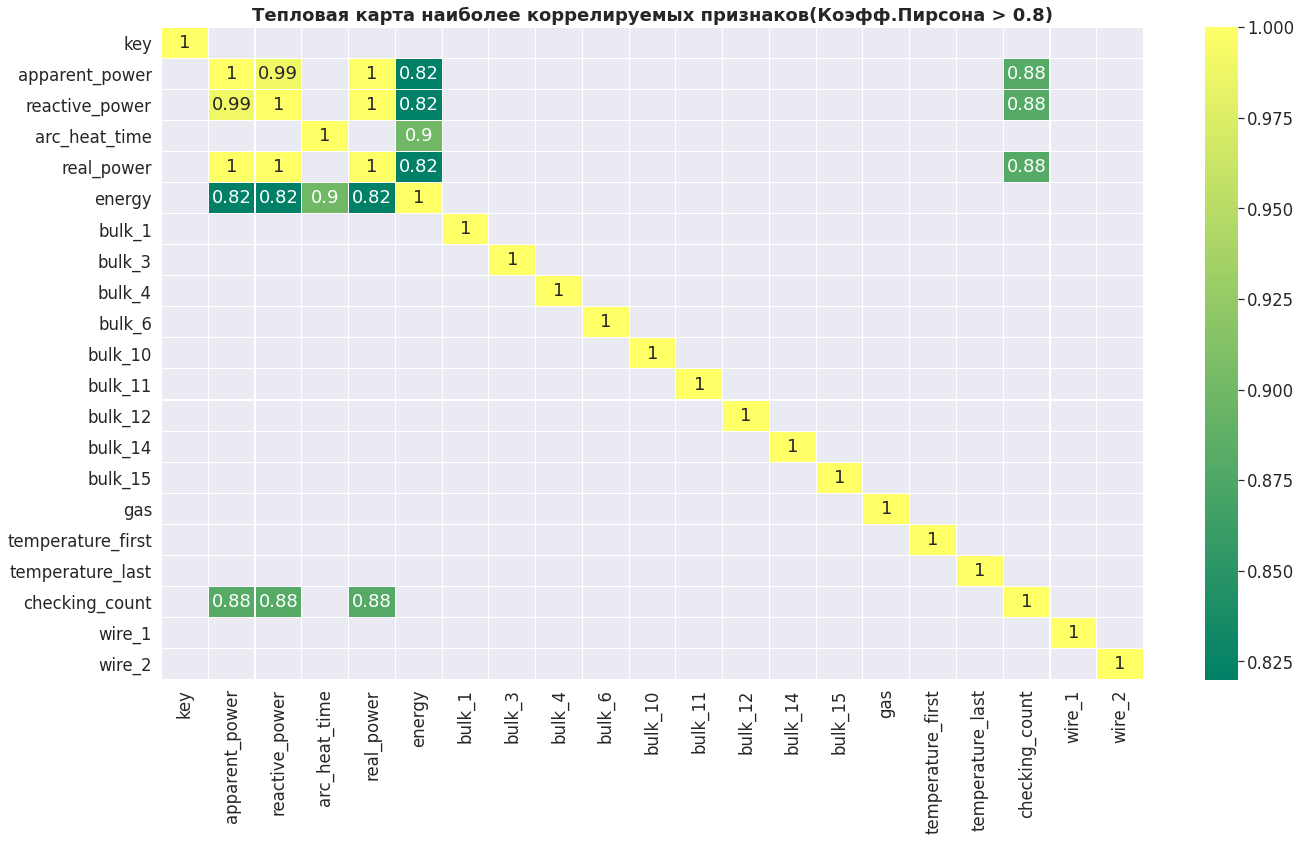

In [51]:
plt.figure(figsize=(22,12))
sns.set(font_scale=1.5)
corr = round(result.corr(),2) 
high_corr_matrix = corr[corr > 0.8]
sns.heatmap(high_corr_matrix,linewidths = 0.05,annot = True,cmap='summer')    

plt.title('Тепловая карта наиболее коррелируемых признаков(Коэфф.Пирсона > 0.8)',fontsize=18, fontweight='bold');


Удаляю наиболее коррелируемые признаки

In [52]:
result = result.drop(['key', 'apparent_power', 'reactive_power', 'arc_heat_time', 'real_power'], axis=1)

Изучим разпределение признаков итогового датафрейма.

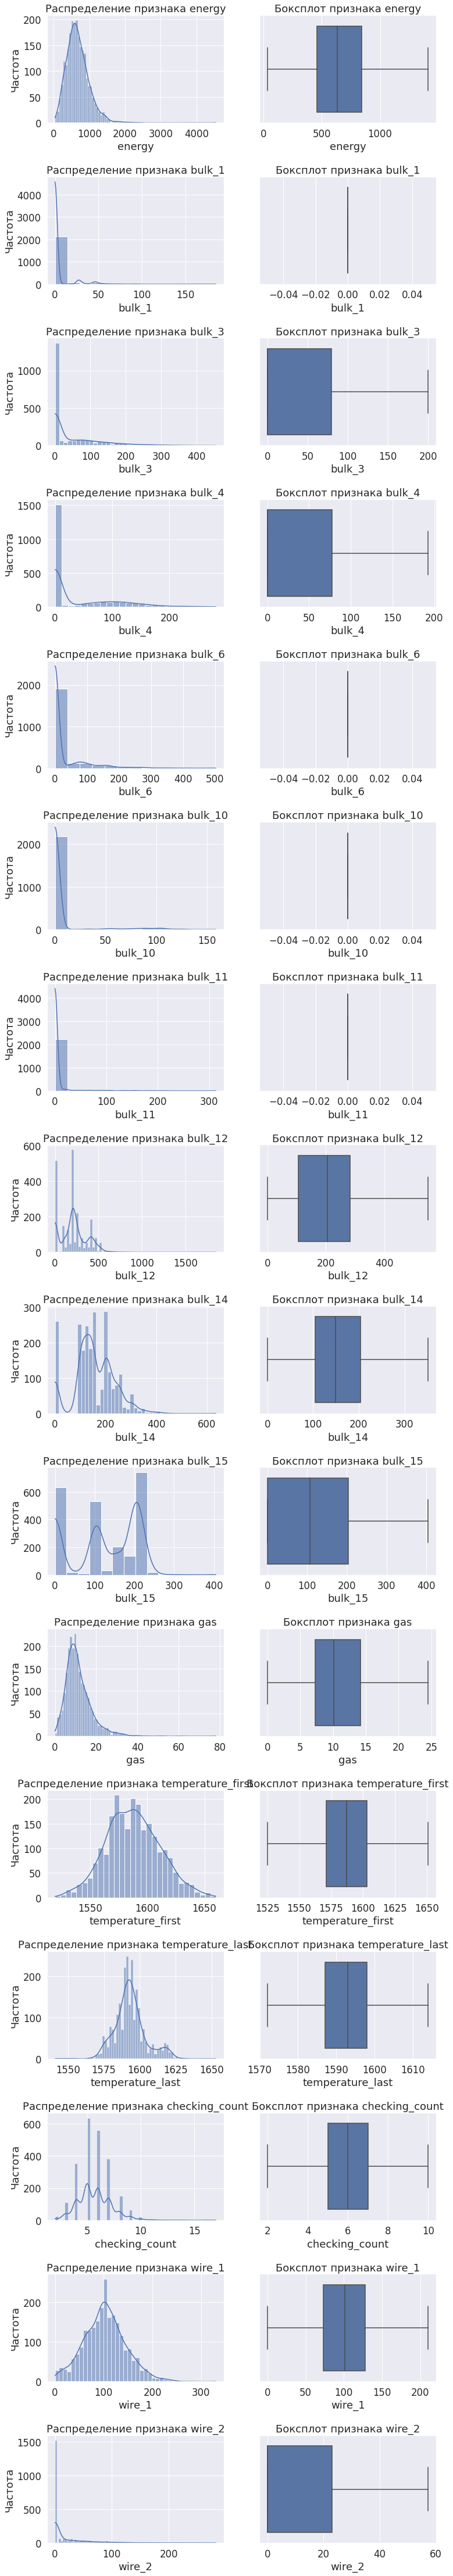

In [53]:
features = result.columns[0:]
fig, axs = plt.subplots(len(features), 2, figsize=(12, 5*len(features)))
plt.subplots_adjust(hspace=0.5)

for i, feature in enumerate(features):
    
    # гистограмма распределения
    sns.histplot(data=result, x=feature, ax=axs[i, 0], kde=True)
    axs[i, 0].set_title(f'Распределение признака {feature}')
    axs[i, 0].set_xlabel(feature)
    axs[i, 0].set_ylabel('Частота')

    # боксплот
    sns.boxplot(data=result, x=feature, ax=axs[i, 1], showfliers=False)
    axs[i, 1].set_title(f'Боксплот признака {feature}')
    axs[i, 1].set_xlabel(feature)
    axs[i, 1].set_ylabel('')


Распределение признаков energy, gas, temperature_last, temperature_first, checking_count, wire_1 имеют нормальное распределение. Остальные данные имеют много нулевых значений, bulk_12, bulk_14, bulk_16 выбросы. Алгоритмы машинного обучения,такие как регрессия на основе деревьев решений, градиентный бустинг, которые я в основном буду использовать, могут хорошо работать с данными, имеющими разные типы распределений.

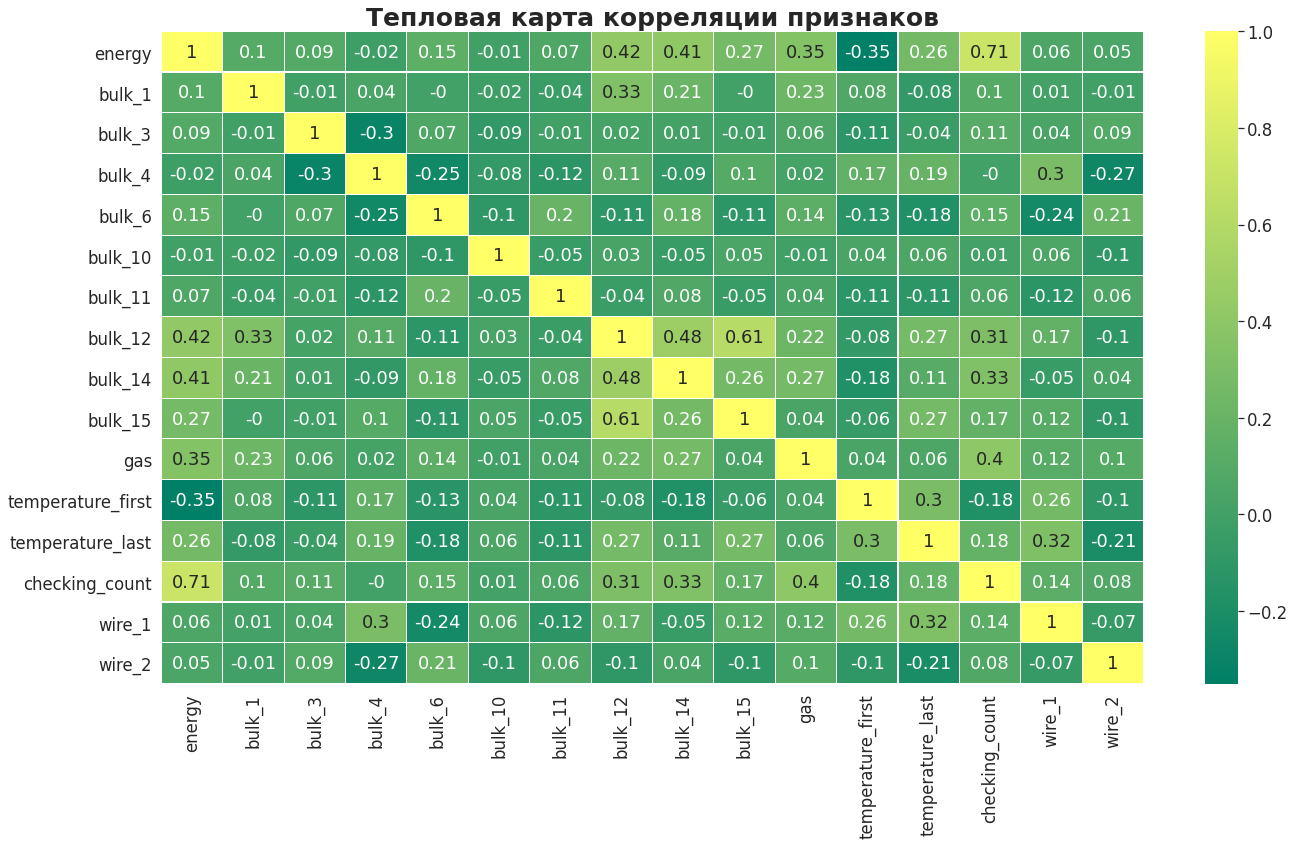

In [54]:
plt.figure(figsize=(22,12))
sns.set(font_scale=1.5)
corr = round(result.corr(),2) 
sns.heatmap(corr,linewidths = 0.05,annot = True,cmap='summer')    
plt.title('Тепловая карта корреляции признаков',fontsize=25, fontweight='bold');


По итоговой тепловой карте особенно выделяются на фоне остальных признаков следующие факты: 

 - зависимость числа проверок температуры от энергии (0,71), после каждой итерации нагрева проверяли температуру, больше нагревов - больше энергии расходуется - больше проверок температуры. 
 - так же прослеживается прямая зависимость количества энергии от обьема сыпучих материалов bulk_12 - 0.42, bulk_14 - 0.41 и от затраченного газа на продувку 0.36 Остальные зависимости очень слабо выражены.
 - так же выделяется прямая зависимость обьемов некоторых сыпучих материалов друг от друга,например:прямая зависимость bulk_12 от обьема bulk_15 (0.61),bulk_14 (0,48), bulk_1(0.33) 
 

## Подготовка выборок для моделирования

Итоговую таблицу очищенную от коррелирующих признаков, разделим на тренировочную и тестовую выборки в соотношении 0.75/0.25

In [55]:
RANDOM_STATE = 110923

result = shuffle(result, random_state=RANDOM_STATE)
features = result.drop(['temperature_last'], axis=1)
target = result['temperature_last']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)
print('Тренировочная выборка- {:.0%}'.format(features_train.shape[0]/result.shape[0]))
print('Тестовая выборка - {:.0%}'.format(features_test.shape[0]/result.shape[0]))

Тренировочная выборка- 75%
Тестовая выборка - 25%


## Обучение моделей регрессии

Для моделирования, рассмотрим несколько моделей различного типа:

 - LinearRegression
 - RandomForest
 - LightGBM
 - CatBoost

Масштабируем числовые признаки при помощи StandartScaler.
Обучение моделей, посредством кросс-валидации и подбором гиперпараметров с помощью GridSearchCV, организую с помощью конвейера pipeline. Создадим так же настраиваемую метрику оценки (mae_scorer) для использования в процессе оценки моделей.

### Pipeline

In [56]:
%%time

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipeline = Pipeline ([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))
                    ])
    
param_grid = [ {        
        'regressor': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'regressor__n_estimators': [10, 50, 100], 
        'regressor__max_depth': [5, 10, 15],
        'regressor__min_samples_split': [2, 4, 8],
         },  
        {
        'regressor' : [LinearRegression()], 
        'regressor__fit_intercept': [True, False],  
        'regressor__normalize': [True, False] 
         },  
       
        {
        'regressor': [CatBoostRegressor(silent=True, random_seed=RANDOM_STATE)],
        'regressor__iterations': range(20, 61, 20), 
        'regressor__learning_rate': np.logspace(-3, 0, 5),
        'regressor__depth': range(3,13,3)
        },   
         {
        'regressor': [ LGBMRegressor(random_state=RANDOM_STATE,objective='regression',force_col_wise=True)],
        'regressor__n_estimators': [40, 60],
        'regressor__num_leaves': [31, 41, 51],
        'regressor__learning_rate':[0.18],
        'regressor__boosting_type':['gbdt'],
        'regressor__metric': ['mae']
         }
        ]
    
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring = mae_scorer, verbose = 3)
grid_search.fit(features_train, target_train)
best_params = grid_search.best_params_ 



Fitting 3 folds for each of 97 candidates, totalling 291 fits
[CV 1/3] END regressor=RandomForestRegressor(random_state=110923), regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV 2/3] END regressor=RandomForestRegressor(random_state=110923), regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV 3/3] END regressor=RandomForestRegressor(random_state=110923), regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=10; total time=   0.0s
[CV 1/3] END regressor=RandomForestRegressor(random_state=110923), regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   0.2s
[CV 2/3] END regressor=RandomForestRegressor(random_state=110923), regressor__max_depth=5, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   0.1s
[CV 3/3] END regressor=RandomForestRegressor(random_state=110923), regressor__max_depth=

## Проверка результатов моделирования

In [57]:
best_params

{'regressor': <catboost.core.CatBoostRegressor at 0x7f6679021cd0>,
 'regressor__depth': 6,
 'regressor__iterations': 40,
 'regressor__learning_rate': 0.1778279410038923}

In [58]:
cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)

best_results_df = results_df.groupby(results_df['param_regressor'].\
                             apply(lambda regressor: regressor.__class__.__name__)).\
                             agg({'mean_test_score': 'max'}).\
                             reset_index()
best_results_df = best_results_df.sort_values(by='mean_test_score', ascending=False)
best_results_df['mean_test_score'] = best_results_df['mean_test_score'].abs()
best_results_df = best_results_df.rename(columns={'mean_test_score':'MAE','param_regressor':'Модель'})

best_results_df

,Модель,MAE
0,CatBoostRegressor,6.687269
3,RandomForestRegressor,6.838209
2,LinearRegression,6.881546
1,LGBMRegressor,7.043057


По результатам обучения моделей на кросс-валидации и подбором гиперпараметров наилучший результат показала градиентная модель CatBoostRegressor c гиперпараметрами 'regressor__depth': 6,'regressor__iterations': 40,'regressor__learning_rate': 0.1778279410038923. Искомая метрика MAE = 6,69. Данную модель будем испытывать в предсказании на тестовой выборке. 

### Предсказание на тестовой выборке

In [59]:
predict = grid_search.best_estimator_.predict(features_test)
MAE_predict = mean_absolute_error(target_test, predict)
print(f'MAE (test): {MAE_predict:.2f}')

MAE (test): 6.27


На тестовой выборке модель показывает результат лучше, что говорит об ее качестве и возможности использования.

### Проверка модели на адекватность

Проверяю финальную модель на адекватность, для чего создаю простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели. К тому же мы сможем быть уверены в качестве ее работы, например, в том, что она выдает не просто набор случайно подобранных данных.

In [60]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
dummy_predicted = dummy.predict(features_test)
result_dummy = mean_absolute_error(target_test, dummy_predicted)
print(f'MAE (dummy): {result_dummy:.2f}')


MAE (dummy): 7.63


Простейшая модель показывает результат хуже,чем CatBoostRegressor с наилучшими гиперпараметрами, это говорит о том что наша модель вполне адекватна. 

### Анализ важности признаков

Теперь посмотрим, как параметры влияют на финальный прогноз

In [61]:
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

In [62]:
importances

array([20.86240075,  5.30995932,  0.39003514,  1.79991879,  7.35334777,
        0.0745428 ,  0.44267512,  8.69226282,  3.10292054,  6.88145475,
        2.41377342, 22.38295103,  1.33126392, 12.2676302 ,  6.69486364])

In [63]:
features_names = result.drop(['temperature_last'], axis=1)
column_list=features_names.columns.tolist()
print(column_list)

['energy', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'gas', 'temperature_first', 'checking_count', 'wire_1', 'wire_2']


In [64]:
importances = pd.DataFrame(importances)
importances.set_index([pd.Index(column_list)], inplace=True)
importances = importances.sort_values(by = 0,ascending=False)
importances.rename(columns={0: "Важность"}, inplace=True)
importances.rename_axis("Признак", inplace=True)
importances.reset_index(inplace=True)


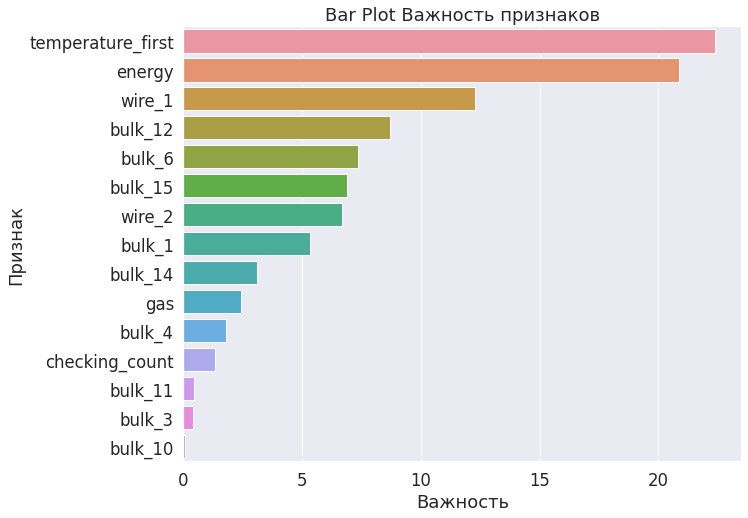

In [65]:
plt.figure(figsize=(10, 8))
sns.barplot(data=importances, x='Важность', y='Признак')
plt.title('Bar Plot Важность признаков');

Как видно из графика, для итоговой метрики в модели CatBoostRegressor наиболее важны параметры:

1)Первое измерение температуры (24,83% важность)
2)Количество энергии, потребляемой при нагреве электродов (16,86% важность).
3)Значение обьемов добавок wire_1, bulk_6,bulk_15,bulk_14,wire_2 (10,3% - 6,52%)

Предприятию стоит обратить внимание на данные параметры, так как они сильно влияют на итоговую температуру.

# Отчет о решении поставленной задачи.

Для выполнения проекта следовал пердварительно составленному плану. По ходу выполнения шагов дополнительно добавил исследование распределения признаков итоговой таблицы, так как это помогает в понимании данных,выбору признаков, нормализации, определению выбросов и определению какие типы моделей использовать в машинном обучении.

1) Изучение и анализ исходных данных показал:

 - имеются значительные пропуски в исходных данных по признакам.
         - в данных по обьему сыпучих материалов(bulk) 71.46% пропусков
         - в данных по времени подачи сыпучих материалов (bulk_time) 71.46%
         - в данных по темпратуре (temp) 6.31%
         - в данных по обьему проволочных материалов(wire) 75.9% пропусков
         - в данных по времени подачи проволочных материалов (wire_time) 75.9% 
 - визуально большинство признаков имеют нормальное распределение.
 - некоторые признаки имеют аномальные выбросы, которые в некоторых случаях являются явными ошибками, например отрицательное значение реактивной мощности в таблице нагрева электродов (arc), и температуры ниже температур плавления стали в таблице температур (temp).
 - по непонятным вопросам сформировал вопросы к заказчику.

2) Следующим этапом исходные данные были предобработаны. Этот этап я бы назвал наиболее сложным с точки зрения понимания технологиии процесса и вытекающие из этого вопросы: какую информацию оставлять, какую удалять, из какой информации можно получить дополнительные признаки.
 - обработал данные, где наблюдались наблюдались явные  аномалии. 
        - Так например: на этапе анализа, было установлено наличие отрицательного значения в реактивной мощности в таблице arc, что скорее всего является ошибкой и такую итерацию нагрева электродов удаляю вместе со всеми итерациями нагревов для данной партии.
        - В таблице temp удалил все партии, замеры текмпературы по которым показали температуру ниже плавления стали 1450 градусов.
        
 - Убрал признаки, по которым были массивные пропуски более 95% таблицах bulk и wire
 - Таблицы  с времиенем подачи добваленных материалов (bulk_time, wire_time) не стал использовать для подготовки итоговой таблицы
 - Добавил дополнительные признаки в таблице arc(энергия затраченная на нагрев электродов) и temp(количество замеров температуры). Удалил партии где замер был всего один.
 - объединенил  таблицы arc_final, temp_final, gas, bulk, wire в общую таблицу для обучения моделей. Данные обьединял по ключу используем inner_jon (т.е. брал только те партии, где есть все данные)
 - Итоговая таблица была проверена на распределение признаков, которое показало что признаки energy, gas, temperature_last, temperature_first, checking_count, wire_1 имеют нормальное распределение. Остальные данные имеют много нулевых значений, bulk_12, bulk_14, bulk_16 выбросы. Алгоритмы машинного обучения,такие как регрессия на основе деревьев решений, градиентный бустинг, которые я в основном буду использовать, могут хорошо работать с данными, имеющими разные типы распределений. 
 - Взаимозависимость признаков показала наличие мултиколлинеарных признаков ('apparent_power', 'reactive_power', 'arc_heat_time', 'real_power') с коэффициентом Пирсона больше 0.8, которые были удалены из итоговой таблицы.По итоговой тепловой карте особенно выделяются на фоне остальных признаков следующие факты:
         - зависимость числа проверок температуры от энергии (0,71), после каждой итерации нагрева проверяли температуру, больше нагревов - больше энергии расходуется - больше проверок температуры.
         -так же прослеживается прямая зависимость количества энергии от обьема сыпучих материалов bulk_12 - 0.42, bulk_14 - 0.41 и от затраченного газа на продувку 0.36 Остальные зависимости очень слабо выражены.
         - так же выделяется прямая зависимость обьемов некоторых сыпучих материалов друг от друга,например:прямая зависимость bulk_12 от обьема bulk_15 (0.61),bulk_14 (0,48), bulk_1(0.33) 

3) Из итоговой таблицы была выделены целевой (last_temperature) и вспомогательные признаки, эти признаки были разбиты на тренирововчную и тестовую выборки с соотношением 0,75/0,25

4) На данных train были обучены и оценены модели линейной регрессии LinearRegression, случайного леса RandomForestRegressor и 2 модели градиентного бустинга CatBoostRegressor и LightGBMRegressor.
 - Масштабирование числовых признаков при помощи StandartScaler, обучение моделей, посредством кросс-валидации и подбором гиперпараметров с помощью GridSearchCV,было реализовано с помощью конвейера pipeline. Так же была создана настраиваемая метрика оценки (mae_scorer) для использования в процессе оценки моделей.

 - По результатам обучения моделей на кросс-валидации и подбором гиперпараметров получились следующие результаты: 
          - CatBoostRegressor          6.687269
          - RandomForestRegressor	   6.838209
          - LinearRegression    	   6.881546
	      - LGBMRegressor              7.043057

наилучший результат показала градиентная модель CatBoostRegressor cо следующими гиперпараметрами:
         
         - 'regressor__depth': 6, глубина дерева. Определяет, насколько глубоко будут расширяться деревья в ансамбле. Большая глубина может привести к переобучению модели.
         - 'regressor__iterations': 40, количество итераций. Определяет, сколько раз будет обучаться модель на всем наборе данных. Большее количество итераций может улучшить точность модели, но может также привести к увеличению времени обучения.
         - 'regressor__learning_rate': 0.1778279410038923, скорость обучения. Определяет, насколько быстро модель будет адаптироваться к данным. Более высокая скорость обучения может ускорить сходимость модели, но может также повлиять на ее точность.
         - random_state:110923,задает начальное состояние для генератора случайных чисел. Это позволяет воспроизводить результаты модели при каждом запуске.

Искомая метрика MAE показала результат = 6.69. MAE (Mean Absolute Error) - средняя абсолютная ошибка. Это метрика, которая используется для оценки качества модели регрессии. MAE показывает среднюю абсолютную разницу между прогнозируемыми и фактическими значениями. Чем меньше значение MAE, тем лучше модель предсказывает целевую переменную. MAE выражается в тех же единицах, что и целевая переменная (в нашем случае это температура в градусах по Цельсию), что делает его легко интерпретируемым. 
Данную модель было решено испытать в предсказании на тестовой выборке.

5) Модель  CAtBoostRegressor ииспользовал в предсказании на тестовой выборке.

 - Итоговый расчёт на тестовых данных выбранной модели показал МАЕ = 6.27, что является успешным результатом по заданию( МАЕ<6.8). 
 - Модель показала адекватность в сравнении с простейшей моделью, у которой метрика МАЕ = 7.63
 - Анализ важности признаков показал, что предприятию рекомендуется включить в наблюдательный процесс такие признаки как: первое измерение температуры; энергия, потребляемая при нагреве электродов. 
 - Так же возможно усовершенствоать систему, которая бы определяла аномальные замеры. 
 
 
 
 


  